In [70]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import RMSprop
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model
from keras.utils import get_custom_objects

In [73]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        # Create a trainable weight variable for the centers of the RBFs
        self.centers = self.add_weight(name='centers',
                                      shape=(self.units, input_shape[-1]),
                                      initializer='uniform',
                                      trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        # Calculate the radial basis functions for each input sample and each RBF center
        diff = K.expand_dims(inputs) - self.centers  # shape: (batch_size, units, input_dim)
        norm = K.sum(K.square(diff), axis=-1)  # shape: (batch_size, units)
        rbf = K.exp(-self.gamma * norm)  # shape: (batch_size, units)

        return rbf

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units
    get_custom_objects().update({'RBFLayer': RBFLayer})

In [72]:
def acc_model(filename):
    # load data
    df = pd.read_csv(filename, delimiter=';')
    # Menentukan input and output
    X = df.drop(columns=["GOAL","7MSHOT","9MSHOT","6MSHOT","WINGSHOT","PIVOTSHOT","FASTBREAKSHOT"])
    y = df.GOAL
    # Membagi data set 80 : 20 train dan test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Merancang Neural Network Model
    model = Sequential()
    model.add(Flatten(input_shape=(6,)))  # Adjust the input shape to (12,)
    model.add(RBFLayer(6, 0.9))
    model.add(Dense(1, activation='linear'))  # Use 'linear' activation for regression
    model.compile(optimizer='rmsprop', loss=mean_squared_error,metrics=['mean_squared_error', 'mean_absolute_error'])

    # Custom callback to collect metrics for plotting
    class MetricsCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            self.mse_values.append(logs['mean_squared_error'])
            self.mae_values.append(logs['mean_absolute_error'])

        def on_train_begin(self, logs=None):
            self.mse_values = []
            self.mae_values = []
        
    metrics_callback = MetricsCallback()
    history = model.fit(X_train, y_train, batch_size=32, epochs=200, validation_data=(X_test, y_test),callbacks=[metrics_callback], verbose=0)
    model.save(f'modelacc_{os.path.splitext(os.path.basename(filename))[0]}.h5')


    # Create a figure with two subplots
    plt.figure(figsize=(16, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation Mean Squared Error
    plt.subplot(1, 2, 2)
    plt.plot(history.epoch, metrics_callback.mse_values, label='Training MSE', color='blue')
    plt.plot(history.epoch, history.history['val_mean_squared_error'], label='Validation MSE', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    
        # data prediction
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    def mean_squared_error1(y_test, pred_test):
        squared_errors = [(true - pred)**2 for true, pred in zip(y_test, pred_test)]
        mse = sum(squared_errors) / len(y_test)
        return mse
    
    mse = mean_squared_error1(y_test, pred_test)
    r2 = r2_score(y_test, pred_test)
    mae = mean_absolute_error(y_test, pred_test)
    print("Manual MSE:", mse)
    print(f"Mean Absolute Error (MAE)",mae)  
    print(f"R2 Score",r2)
    
    return model
def shot_model(filename):
    # load data
    df = pd.read_csv(filename, delimiter=';')
    # Menentukan input and output
    X = df.drop(columns=["GOAL","7MACC","9MACC","6MACC","WINGACC","PIVOTACC","FASTBREAKACC"])
    y = df.GOAL
    # Membagi data set 80 : 20 train dan test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Normalisasi data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Merancang Neural Network Model
    model = Sequential()
    model.add(Flatten(input_shape=(6,)))  # Adjust the input shape to (12,)
    model.add(RBFLayer(6, 0.9))
    model.add(Dense(1, activation='linear'))  # Use 'linear' activation for regression
    model.compile(optimizer='rmsprop', loss=mean_squared_error,metrics=['mean_squared_error', 'mean_absolute_error'])

    # Custom callback to collect metrics for plotting
    class MetricsCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            self.mse_values.append(logs['mean_squared_error'])
            self.mae_values.append(logs['mean_absolute_error'])

        def on_train_begin(self, logs=None):
            self.mse_values = []
            self.mae_values = []
        
    metrics_callback = MetricsCallback()
    history = model.fit(X_train, y_train, batch_size=32, epochs=200, validation_data=(X_test, y_test),callbacks=[metrics_callback], verbose=0)
    model.save(f'modelshott_{os.path.splitext(os.path.basename(filename))[0]}.h5')
   
    # Create a figure with two subplots
    plt.figure(figsize=(16, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation Mean Squared Error
    plt.subplot(1, 2, 2)
    plt.plot(history.epoch, metrics_callback.mse_values, label='Training MSE', color='blue')
    plt.plot(history.epoch, history.history['val_mean_squared_error'], label='Validation MSE', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
        # data prediction
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    def mean_squared_error1(y_test, pred_test):
        squared_errors = [(true - pred)**2 for true, pred in zip(y_test, pred_test)]
        mse = sum(squared_errors) / len(y_test)
        return mse
    
    mse = mean_squared_error1(y_test, pred_test)
    r2 = r2_score(y_test, pred_test)
    mae = mean_absolute_error(y_test, pred_test)
    print("Manual MSE:", mse)
    print(f"Mean Absolute Error (MAE)",mae)  
    print(f"R2 Score",r2)
    
    

    return model

Position:  CB.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


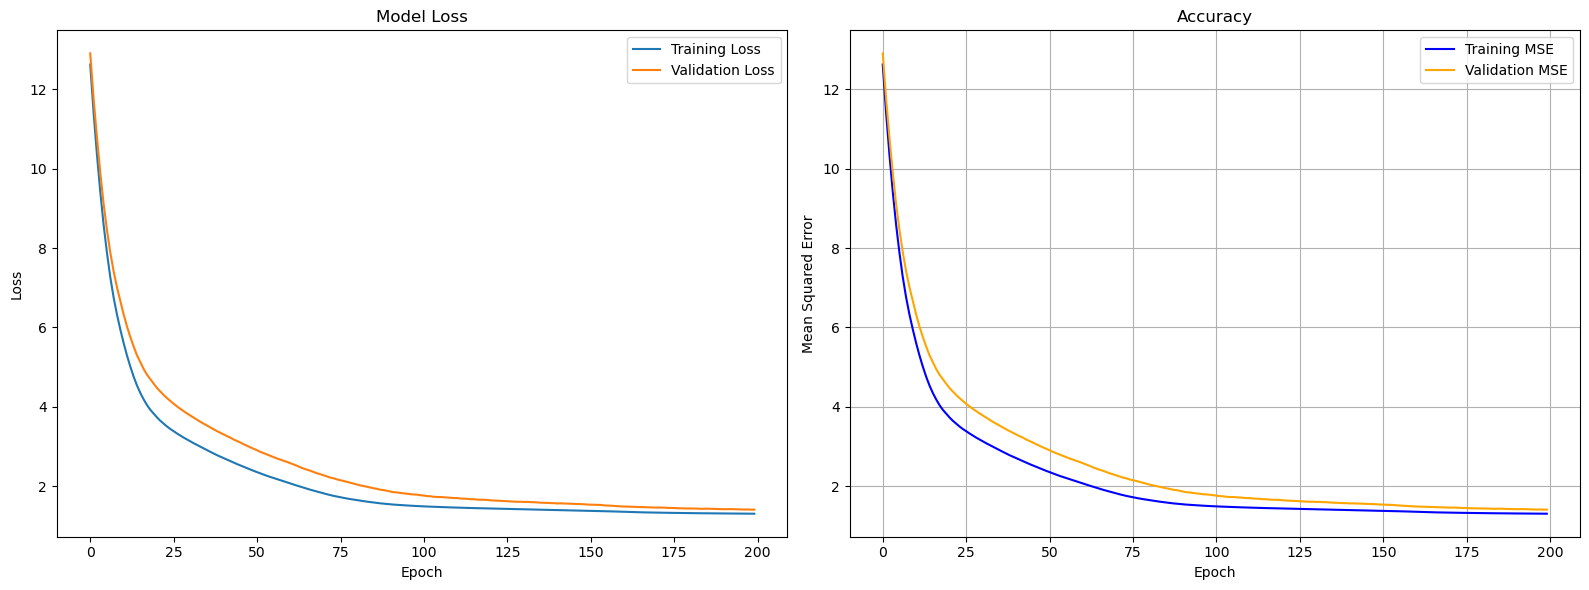

9/9 [==============================] - 0s 946us/step
Manual MSE: [1.406418]
Mean Absolute Error (MAE) 0.7741601584955703
R2 Score 0.7093437514176744

Position:  LB.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


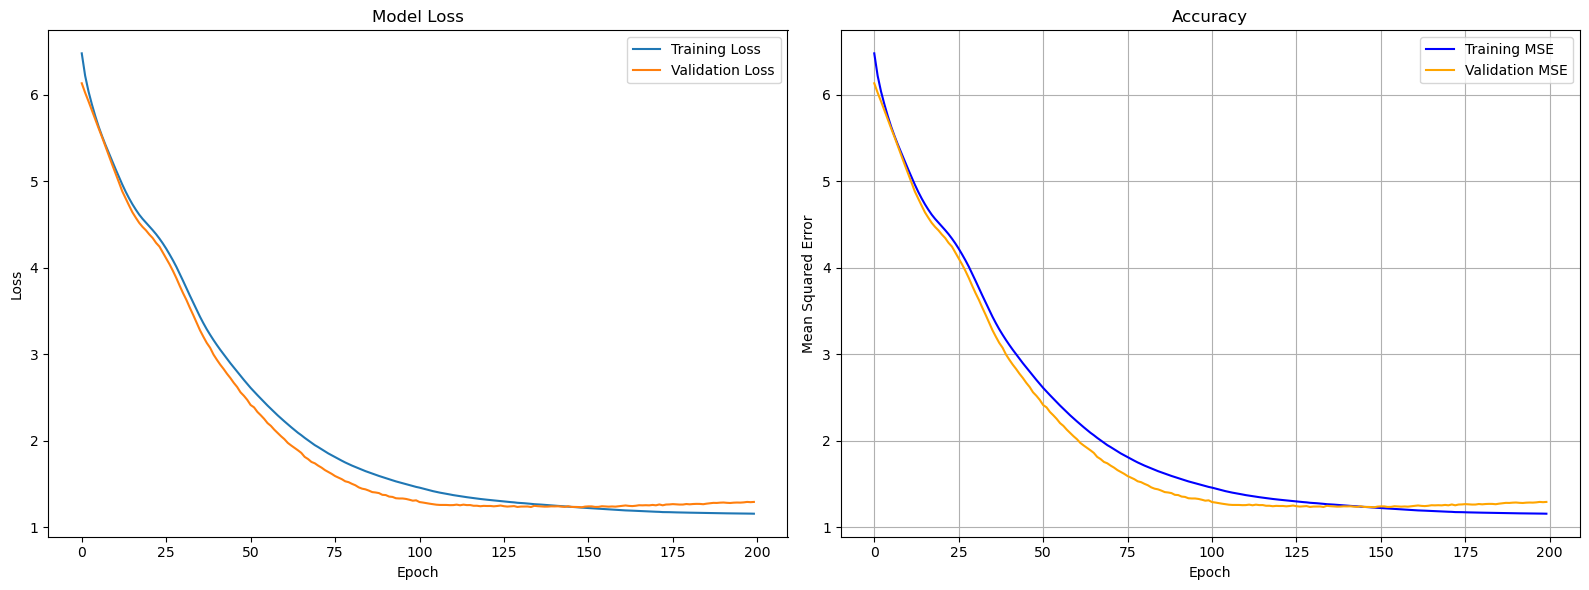

10/10 [==============================] - 0s 1ms/step
Manual MSE: [1.2949876]
Mean Absolute Error (MAE) 0.7492635506667839
R2 Score 0.721797590249692

Position:  LW.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


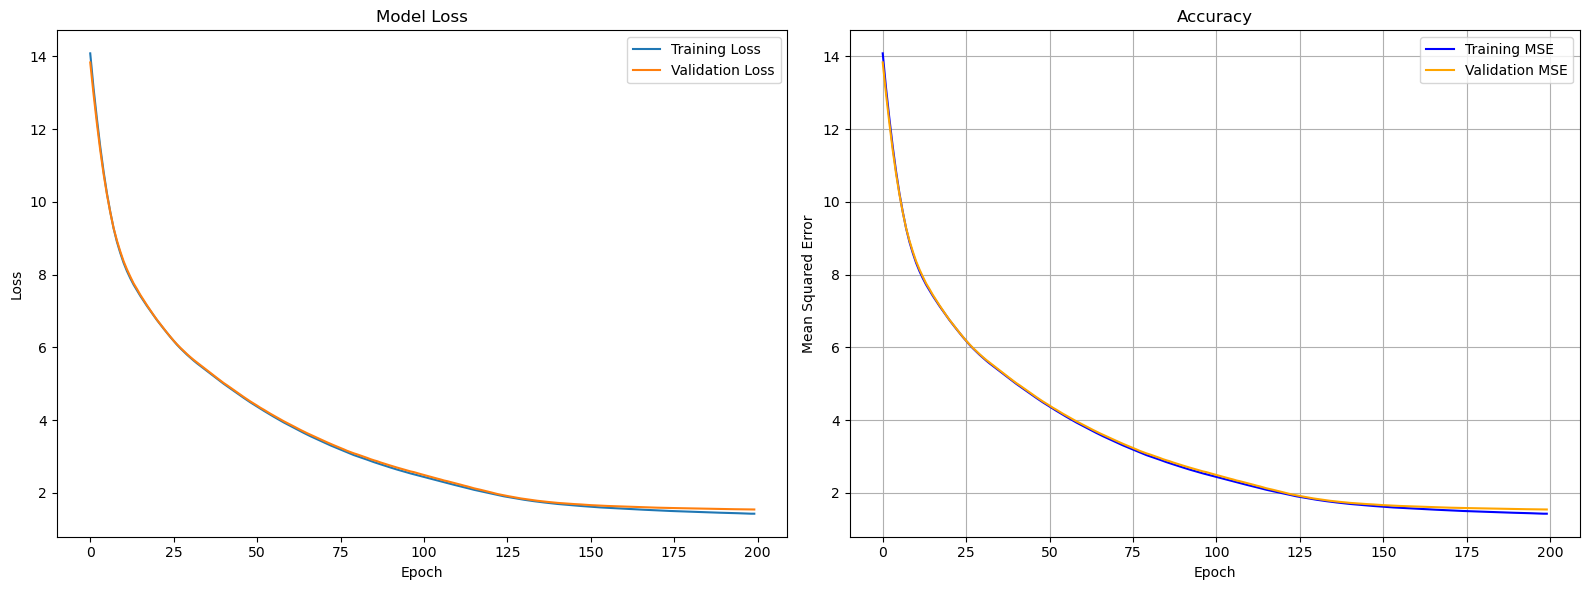

8/8 [==============================] - 0s 1ms/step
Manual MSE: [1.5469191]
Mean Absolute Error (MAE) 0.7890120682509049
R2 Score 0.7776962561117626

Position:  P.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


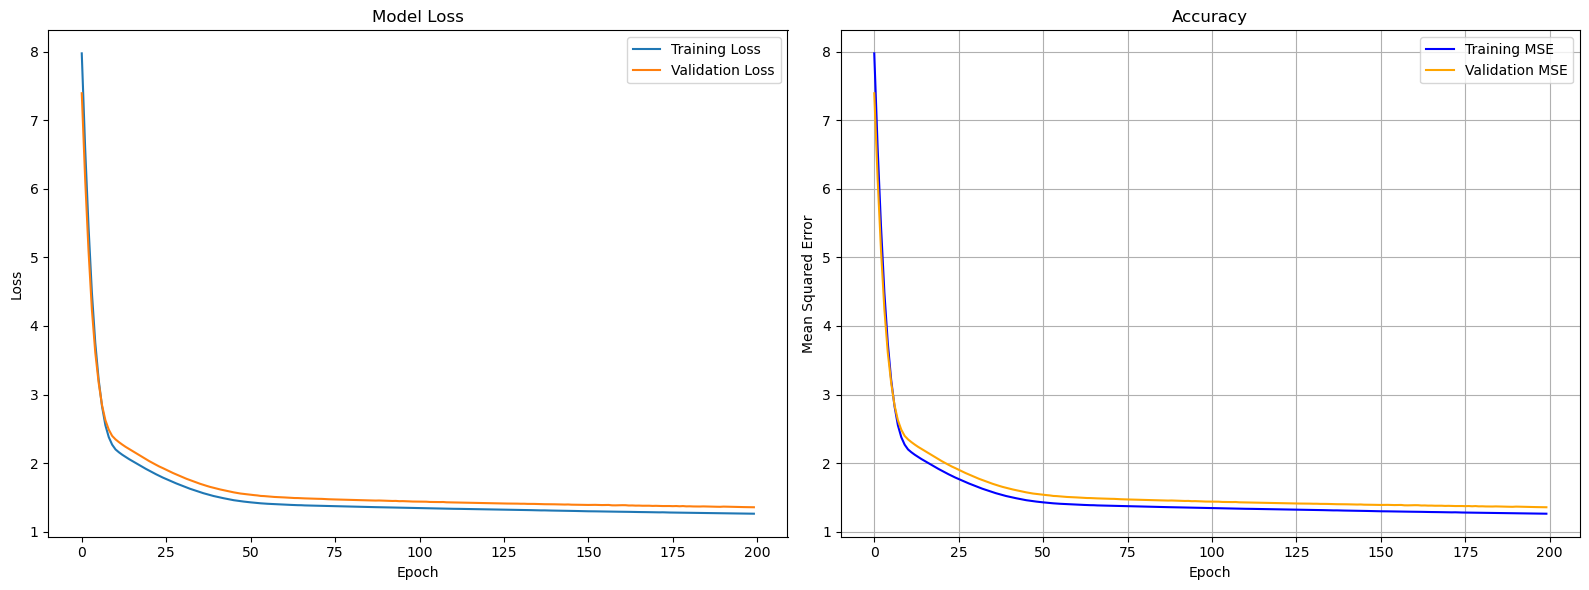

10/10 [==============================] - 0s 997us/step
Manual MSE: [1.3569753]
Mean Absolute Error (MAE) 0.7177460898760877
R2 Score 0.5712589308860457

Position:  RB.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


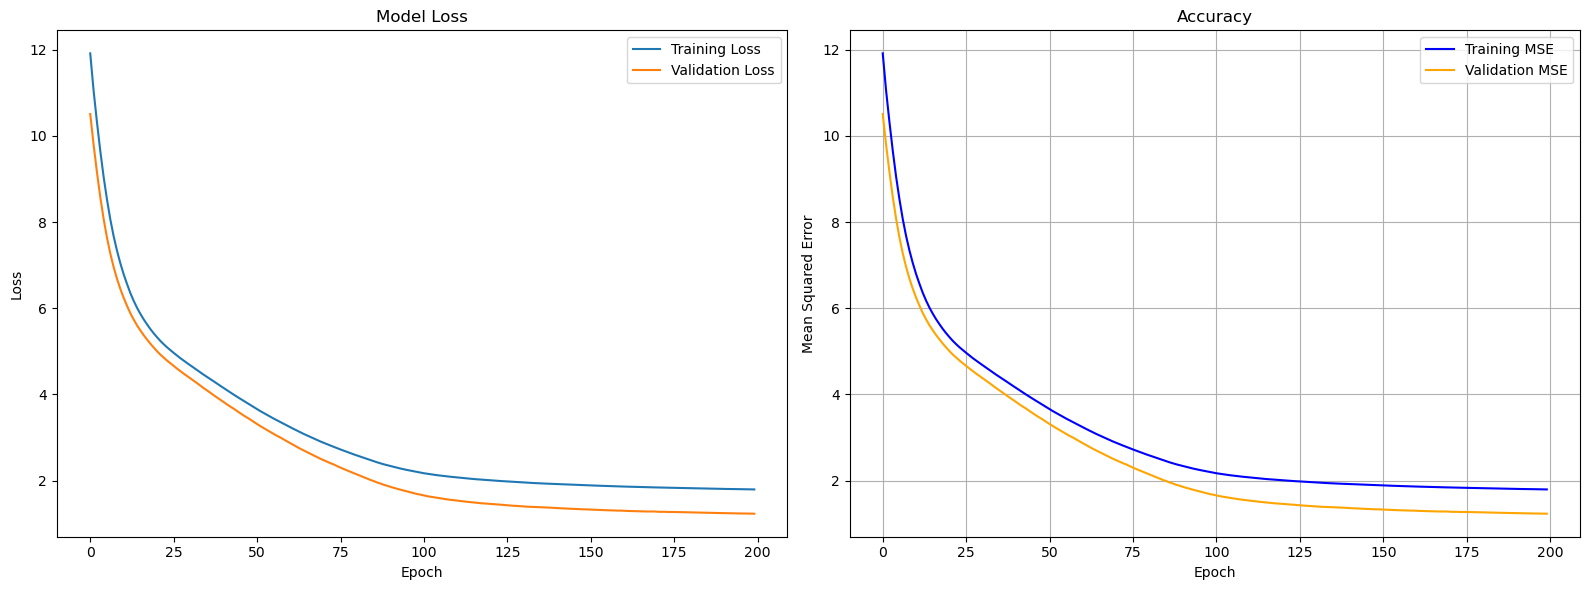

7/7 [==============================] - 0s 2ms/step
Manual MSE: [1.2340604]
Mean Absolute Error (MAE) 0.710597509687597
R2 Score 0.7883496735386906

Position:  RW.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


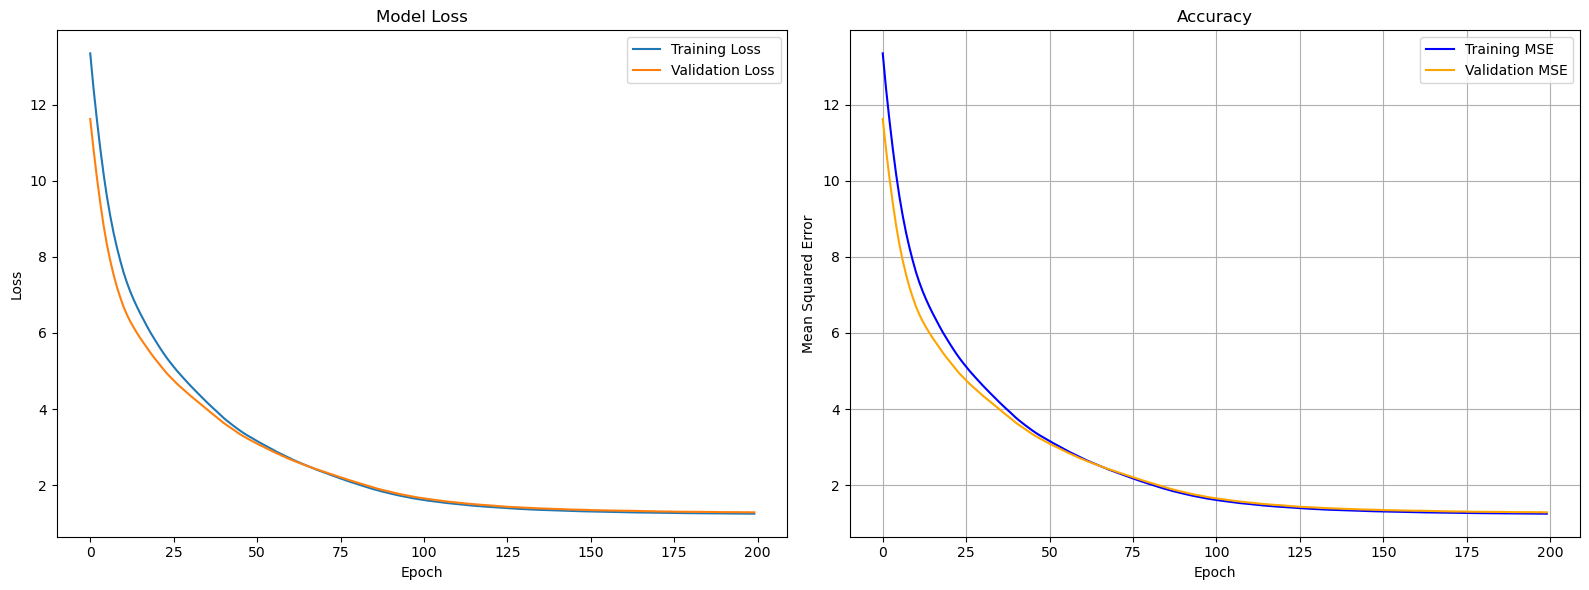

8/8 [==============================] - 0s 1ms/step
Manual MSE: [1.2867817]
Mean Absolute Error (MAE) 0.7236435952393905
R2 Score 0.7765095035476166



In [64]:
for i in os.listdir('data/'):
    print('Position: ', i.split(',')[0])
    acc_model('data/'+i)
    print('')

Position:  CB.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


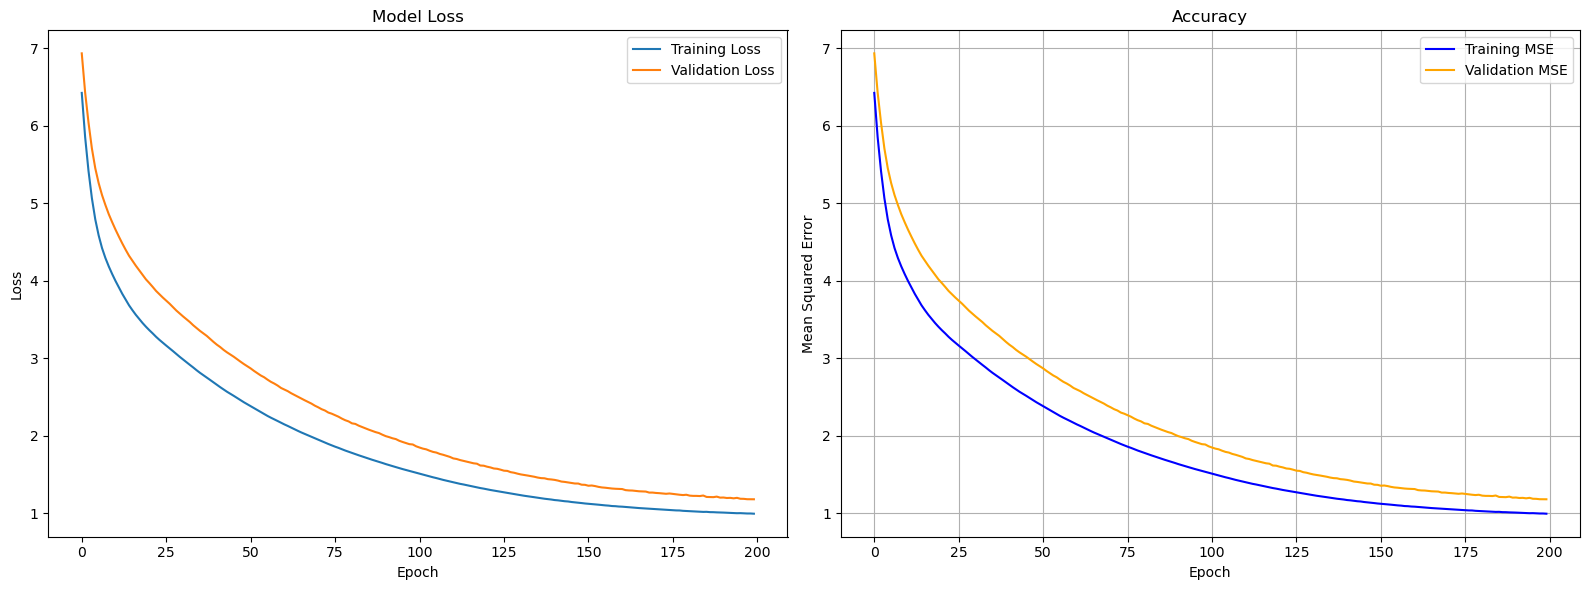

9/9 [==============================] - 0s 1ms/step
Manual MSE: [1.1816427]
Mean Absolute Error (MAE) 0.7388358945532363
R2 Score 0.7557968707641195

Position:  LB.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


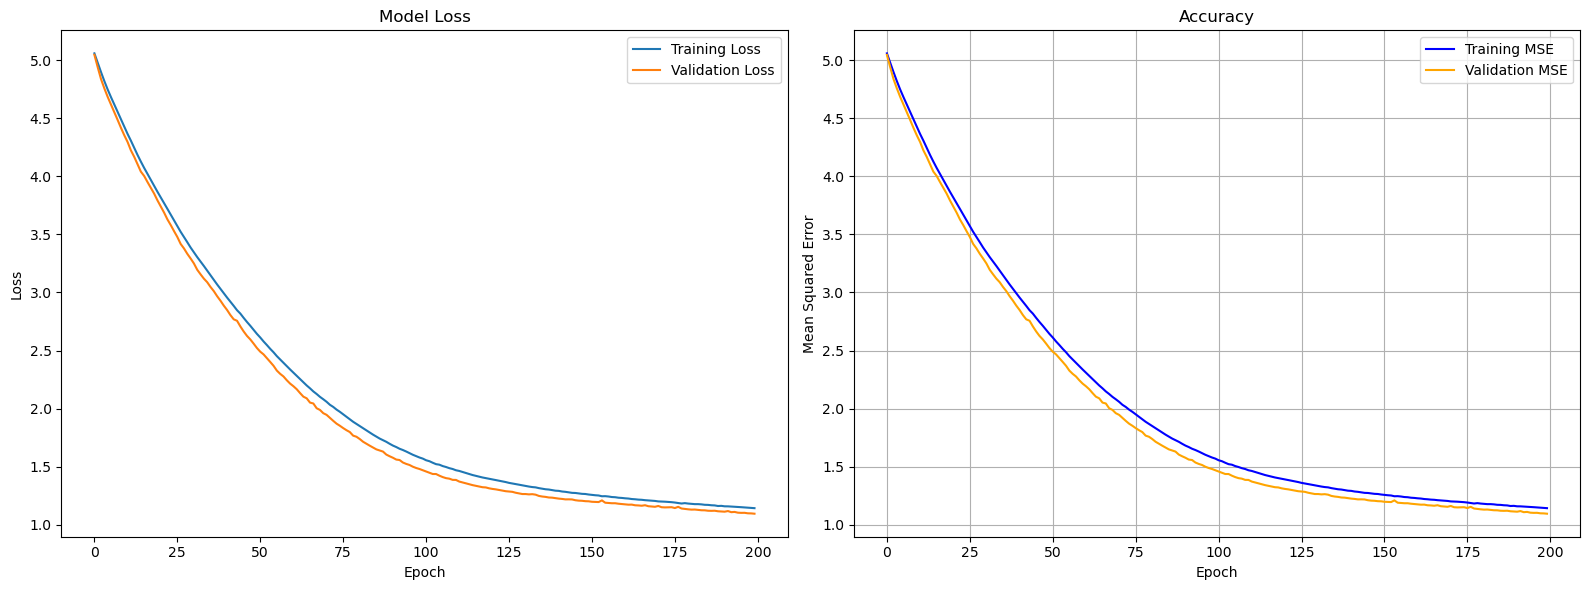

10/10 [==============================] - 0s 1ms/step
Manual MSE: [1.096063]
Mean Absolute Error (MAE) 0.7010828090819302
R2 Score 0.7645327863314819

Position:  LW.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


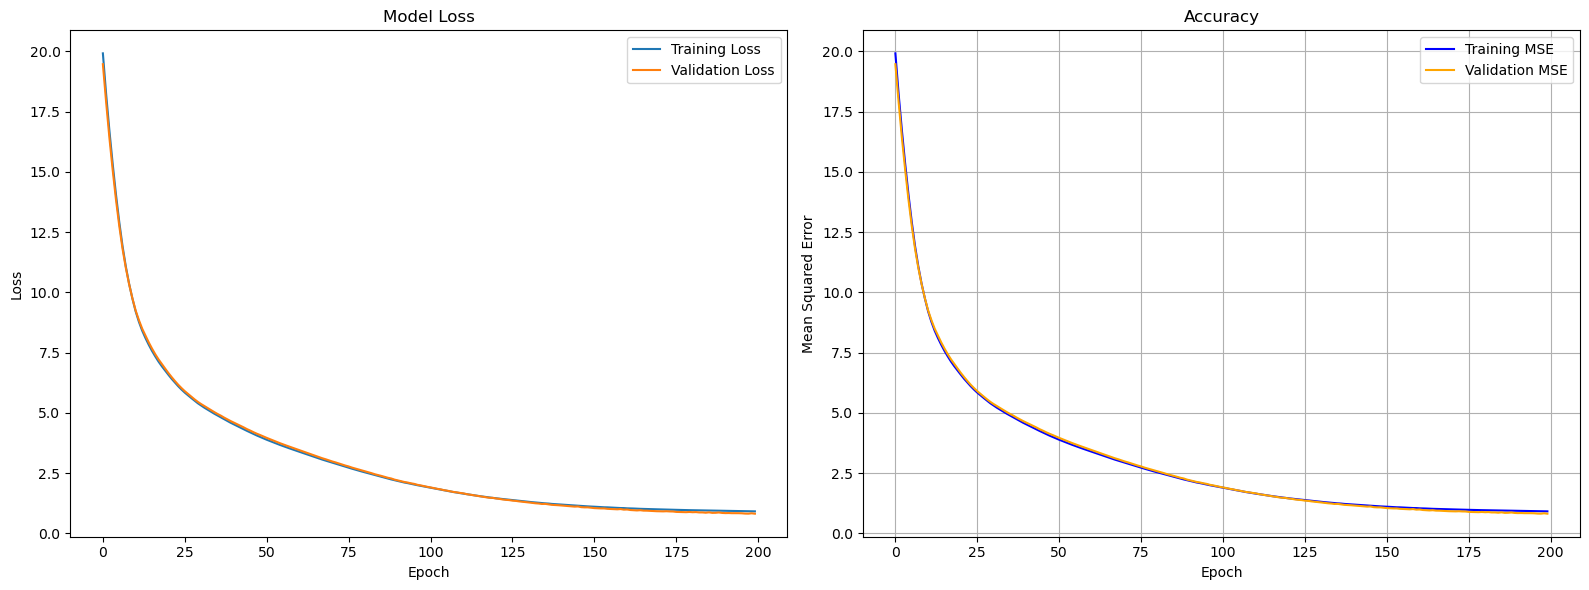

8/8 [==============================] - 0s 1ms/step
Manual MSE: [0.81226945]
Mean Absolute Error (MAE) 0.6019654486490332
R2 Score 0.8832709143191

Position:  P.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


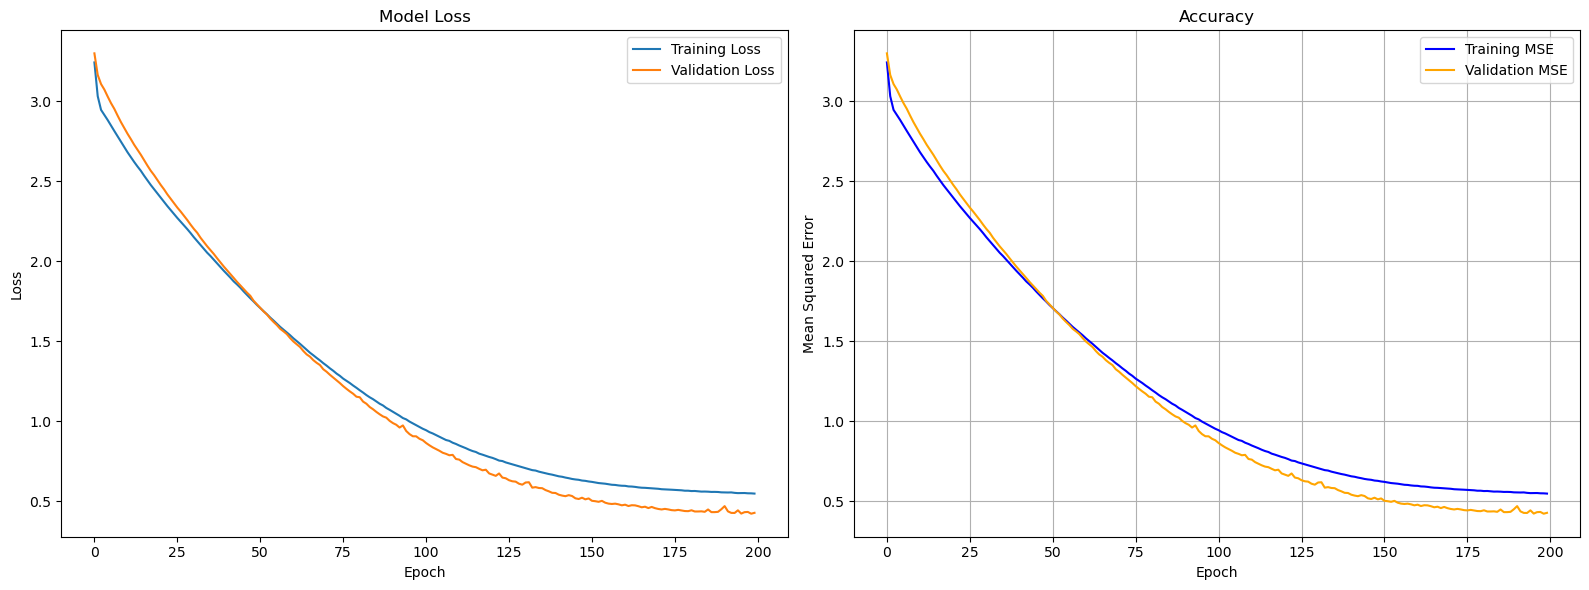

10/10 [==============================] - 0s 1ms/step
Manual MSE: [0.4280712]
Mean Absolute Error (MAE) 0.4549809667020062
R2 Score 0.8647495062346844

Position:  RB.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


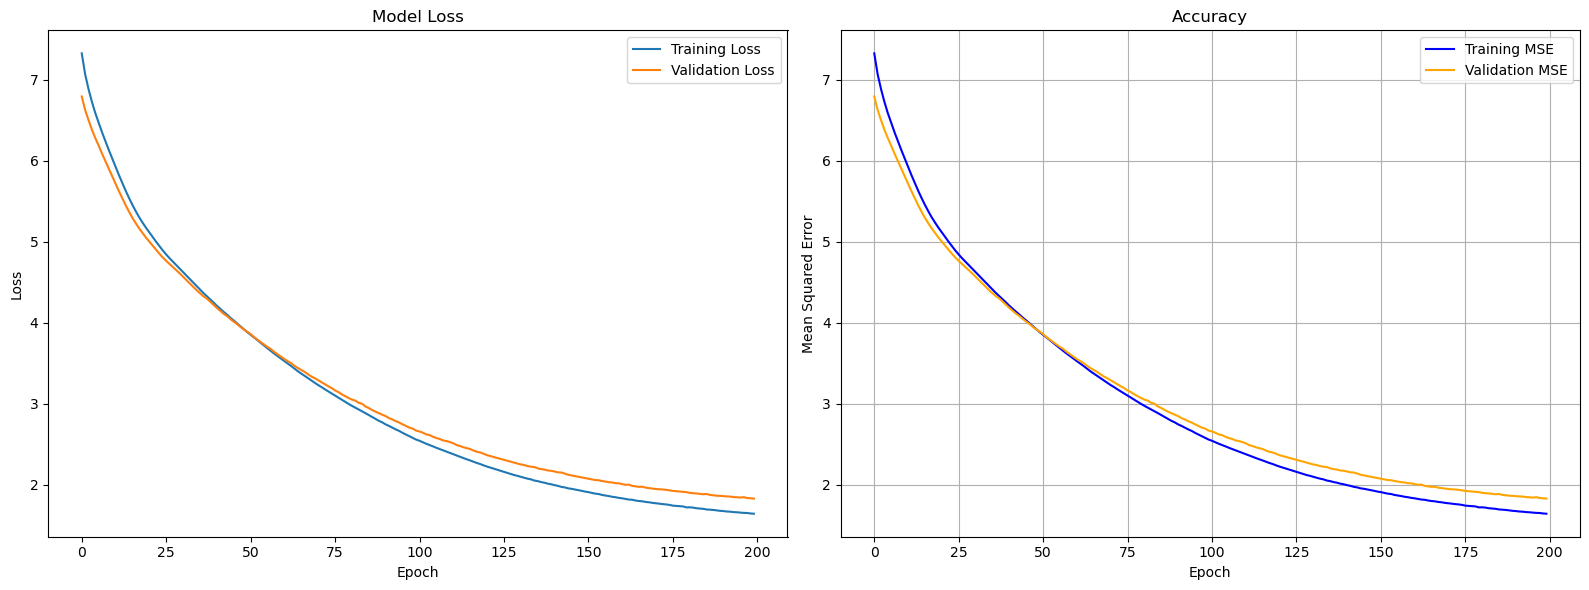

7/7 [==============================] - 0s 1ms/step
Manual MSE: [1.8279734]
Mean Absolute Error (MAE) 0.9552078756419096
R2 Score 0.6864894737834455

Position:  RW.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


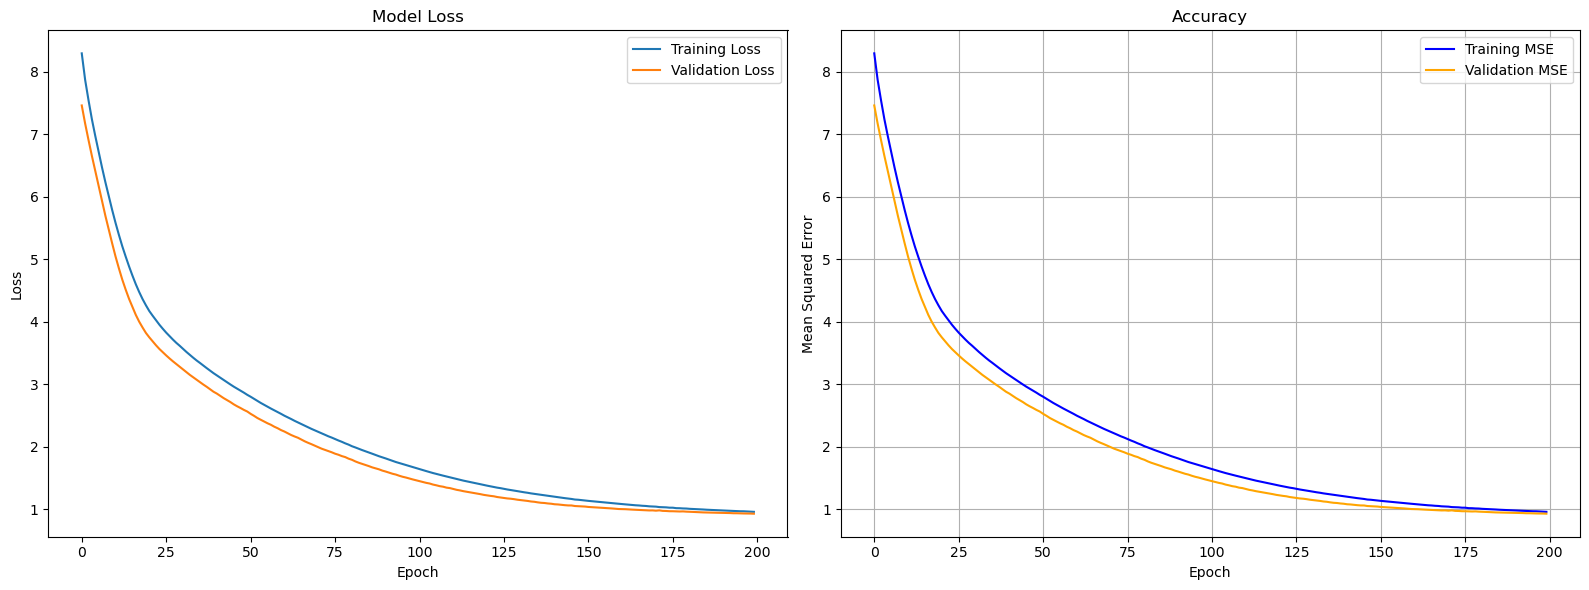

8/8 [==============================] - 0s 2ms/step
Manual MSE: [0.92812896]
Mean Absolute Error (MAE) 0.6470287416292273
R2 Score 0.838800817295764



In [ ]:
for i in os.listdir('data/'):
    print('Position: ', i.split(',')[0])
    shot_model('data/'+i)
    print('')

In [15]:
urlacc = 'https://raw.githubusercontent.com/ravsssh/HandballPrediction/main/Handball%20Prediction/data/Sensitivity/ACC.csv'
acc_df = pd.read_csv(urlacc, delimiter = ';')
acc_sensitivity = model.predict(acc_df)
print(acc_sensitivity)

3/3 [==============================] - 0s 2ms/step
[[ 0.00868928]
 [ 0.1381185 ]
 [ 0.3270446 ]
 [ 0.58261335]
 [ 0.901345  ]
 [ 1.2648517 ]
 [ 1.6387587 ]
 [ 1.9765654 ]
 [ 2.2285466 ]
 [ 2.35359   ]
 [ 2.3301525 ]
 [ 0.00868928]
 [ 0.32077777]
 [ 0.7189599 ]
 [ 1.1847535 ]
 [ 1.6784564 ]
 [ 2.1423304 ]
 [ 2.5106585 ]
 [ 2.7246952 ]
 [ 2.747952  ]
 [ 2.5763676 ]
 [ 2.239465  ]
 [ 0.00868928]
 [ 0.37318814]
 [ 0.7304874 ]
 [ 1.045946  ]
 [ 1.3004481 ]
 [ 1.4896561 ]
 [ 1.6199757 ]
 [ 1.7034341 ]
 [ 1.753257  ]
 [ 1.7810352 ]
 [ 1.7955196 ]
 [ 0.00868928]
 [ 0.18046021]
 [ 0.3059728 ]
 [ 0.36462545]
 [ 0.34628773]
 [ 0.2541597 ]
 [ 0.1038599 ]
 [-0.08090317]
 [-0.274428  ]
 [-0.45473713]
 [-0.6072231 ]
 [ 0.00868928]
 [ 0.06079191]
 [ 0.15235782]
 [ 0.26872772]
 [ 0.3933109 ]
 [ 0.5113894 ]
 [ 0.6127228 ]
 [ 0.6924257 ]
 [ 0.75030226]
 [ 0.78928643]
 [ 0.81372297]
 [ 0.00868928]
 [ 0.1262601 ]
 [ 0.2813057 ]
 [ 0.46939498]
 [ 0.67730063]
 [ 0.8832112 ]
 [ 1.0598516 ]
 [ 1.1801825 ]
 [ 1

In [12]:
pd.DataFrame(acc_sensitivity).to_csv('sensitivitasaccuracy.xls', index=False)